# Example 7: Simulating the Earliest Possible Sowing Date for Millet in Mali using different satellite rainfall estimation products, and comparing with observed sowing dates

*** based on example 2, this description has to be updated ***

The aim of this notebook is to help determine, for each satellite rainfall estimation product in between TAMSAT, CHIRPS, IMERG and PrISM, which threshold value for surface water stock should be used in order to best represent the variability in the mean sowing dates per department as declared through the LSMS-ISA permanent agricultural survey.

For this, we first perform a SARRA water balance simulation run with each of the satellite rainfall estimation product. Then, we apply different threshold values to the surface water stock and compare the resulting mean sowing dates per department with the LSMS-ISA data. This will allow to determine the best threshold value for each satellite rainfall estimation product, and the overall best satellite rainfall estimation product to use for this exercice.

In this notebook, we will work on determining the surface water stock threshold to use in subsequent analyses.

basé sur la première version du notebook qui prend en compte iSDA

## Imports

In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import io
import xarray as xr
from sarra_py import *
import time
import geopandas as gpd
from scipy.stats import pearsonr
import plotly.express as px
import warnings

## Simulation parameters

In [2]:
# weather and rainfall data path
rainfall_data_path_TAMSAT = "/mnt/g/Mon Drive/CIRAD/draft paper sowing date satellite rainfall products/data/rfe/TAMSAT_v3.1_south_mali_rfe_filled" 
rainfall_data_path_CHIRPS = "/mnt/g/Mon Drive/CIRAD/draft paper sowing date satellite rainfall products/data/rfe/CHIRPS_v2.0_Africa_south_mali"  
rainfall_data_path_IMERG = "/mnt/g/Mon Drive/CIRAD/draft paper sowing date satellite rainfall products/data/rfe/IMERG_south_mali_band_data" 
rainfall_data_path_PrISM = "/mnt/g/Mon Drive/CIRAD/draft paper sowing date satellite rainfall products/data/rfe/PrISM_south_mali" 

rainfall_data_paths = {"TAMSAT": rainfall_data_path_TAMSAT, 
                       "CHIRPS": rainfall_data_path_CHIRPS,
                       "IMERG": rainfall_data_path_IMERG,
                       "PrISM": rainfall_data_path_PrISM}

climate_data_path = "/mnt/g/Mon Drive/CIRAD/draft paper sowing date satellite rainfall products/data/weather/AgERA5_south_mali/"

# parameter files
file_paramVariete = "millet_variety.yaml"
file_paramITK = "millet_niger_2017.yaml"
file_paramTypeSol = "USA_iowa_V42.yaml"

## Running the simulations

We run one water balance simulation per satellite rainfall estimation product, and populate the `simulation_output` dictionary with the results.

In [3]:
multiyear_simulation_output = {}

years = [2014, 2017]

for year in years :

    # simulation parameters
    date_start = datetime.date(year,1,1)
    duration = 220 # days

    # initialize a dictionary to store simulation results
    simulation_output = {}

    # as we want to study the variation of sowing date using different satellite rainfall estimates, we perform one simulation per rainfall dataset
    for rainfall_data_name in tqdm(rainfall_data_paths):

        # setting the data path according to the rainfall dataset
        rainfall_data_path = rainfall_data_paths[rainfall_data_name]

        # retrieving the grid size from the rainfall data (this method will be deprecated in the future)
        grid_width, grid_height = get_grid_size(rainfall_data_path, date_start, duration)

        ## preparing the base dataset
        # initialize empty xarray dataset to load base data
        base_data = xr.Dataset()

        # load rainfall and weather data
        base_data = load_TAMSAT_data(base_data, rainfall_data_path, date_start, duration)
        base_data = load_AgERA5_data(base_data, climate_data_path, date_start, duration)

        # load soil data using the iSDA method (uses more recent maps)
        # base_data = load_iSDA_soil_data_alternate(base_data, grid_width, grid_height)
        base_data = load_iSDA_soil_data(base_data, grid_width, grid_height)

        # compute the day length
        base_data = calc_day_length_raster_fast(base_data, date_start, duration)    

        ## prepating simulation dataset
        # load variety, cropping system and soil parameters
        paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)

        # creating simulation xarray dataset by copying the base data
        data = base_data.copy()

        # initializing all the necessary variables
        data = initialize_simulation(data, grid_width, grid_height, duration, paramVariete, paramITK, date_start)
        data = initialize_default_irrigation(data)
        data = calculate_once_daily_thermal_time(data, paramVariete)

        ## running the model
        data = run_waterbalance_model(paramVariete, paramITK, paramTypeSol, data, duration)

        # storing the results in a dictionary
        simulation_output[rainfall_data_name] = data["surface_tank_stock"]

        # free memory
        del base_data, data

    # storing the results in a dictionary
    multiyear_simulation_output[year] = simulation_output

  0%|          | 0/4 [00:00<?, ?it/s]

2m_temperature_24_hour_maximum
2m_temperature_24_hour_mean


2m_temperature_24_hour_minimum
ET0Hargeaves


solar_radiation_flux_daily


 25%|██▌       | 1/4 [03:30<10:32, 210.79s/it]

2m_temperature_24_hour_maximum
2m_temperature_24_hour_mean


2m_temperature_24_hour_minimum
ET0Hargeaves


solar_radiation_flux_daily


 50%|█████     | 2/4 [06:21<06:14, 187.09s/it]

2m_temperature_24_hour_maximum
2m_temperature_24_hour_mean


2m_temperature_24_hour_minimum
ET0Hargeaves


solar_radiation_flux_daily


 75%|███████▌  | 3/4 [08:45<02:47, 167.69s/it]

2m_temperature_24_hour_maximum
2m_temperature_24_hour_mean


2m_temperature_24_hour_minimum
ET0Hargeaves


solar_radiation_flux_daily


  0%|          | 0/4 [00:00<?, ?it/s]

2m_temperature_24_hour_maximum
2m_temperature_24_hour_mean


2m_temperature_24_hour_minimum
ET0Hargeaves


solar_radiation_flux_daily


 25%|██▌       | 1/4 [03:17<09:51, 197.09s/it]

2m_temperature_24_hour_maximum
2m_temperature_24_hour_mean


2m_temperature_24_hour_minimum
ET0Hargeaves


solar_radiation_flux_daily


 50%|█████     | 2/4 [06:15<06:12, 186.20s/it]

2m_temperature_24_hour_maximum
2m_temperature_24_hour_mean


2m_temperature_24_hour_minimum
ET0Hargeaves


solar_radiation_flux_daily


 75%|███████▌  | 3/4 [08:40<02:47, 167.10s/it]

2m_temperature_24_hour_maximum
2m_temperature_24_hour_mean


2m_temperature_24_hour_minimum
ET0Hargeaves


solar_radiation_flux_daily


100%|██████████| 4/4 [11:01<00:00, 165.27s/it]


## Visualizing some results

Let's plot some results to see what we have done. Starting with dynamics of surface tank stock.

In [ ]:
rainfall_data_name = "CHIRPS"
time_resolution = 5

vmax = simulation_output[rainfall_data_name].max().values
gdf = gpd.read_file("https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_NER_shp.zip")
for i in range(int(round(duration/time_resolution,0))):
    simulation_output[rainfall_data_name][time_resolution*i,:,:].plot(vmin=0, vmax=vmax)
   
    gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
    plt.title("Day %s" % (i*time_resolution))
    plt.show()

Create a map of the first day at which the surface tank reaches a given threshold (arbitrary)

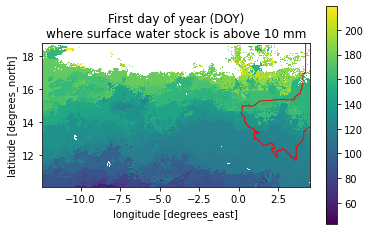

In [5]:
rainfall_data_name = "CHIRPS"
threshold = 10 # mm

# creates a map of the first day at which the surface tank reaches the threshold
# argmax returns the index of the first True value along the time axis, that is here the DOY as simulation started on Jan. 1st
argmax = (simulation_output[rainfall_data_name] > threshold).argmax(axis=0)
result = xr.where(argmax==0,np.nan,argmax)

# hide the original variable name
result.name = None

# rename the axes
result = result.rename({'x':'longitude [degrees_east]','y':'latitude [degrees_north]'})
result.plot()

# draw the country borders
gdf = gpd.read_file("https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_NER_shp.zip")
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)

# add title
plt.title("First day of year (DOY)\nwhere surface water stock is above {} mm".format(threshold))

# display figure
plt.show()

## Analysis of correlation between estimated sowing date with the observed sowing date at department level from the LSMS-ISA data

Our observed sowing date values have been produced by crunching the numbers in the 2014 LSMS-ISA data for Niger. We calculated the mean date for each departement for successful millet sowing. 

In [32]:
species = "peanut"

observed_sowing_dates_df_total = pd.DataFrame()
for year in years:
    observed_sowing_dates_df = pd.read_csv("/mnt/g/Mon Drive/CIRAD/draft paper sowing date satellite rainfall products/notebooks/Mali_"+str(year)+"_sowing_"+species+"_filtered.csv")
    observed_sowing_dates_df["year"] = year
    observed_sowing_dates_df_total = observed_sowing_dates_df_total.append(observed_sowing_dates_df)

observed_sowing_dates_df_total = observed_sowing_dates_df_total.reset_index(drop=True)

In [33]:
# # load administrative boundaries for Niger departements (ADM2 level)
# departments_gdf = gpd.read_file("../notebooks/exemple_2_satellite_rainfall_sowing_date/ner_adm02_feb2018/NER_adm02_feb2018.shp")

# # load observed values for mean first plausible sowing date per department
# observed_sowing_dates_df = pd.read_csv("../notebooks/exemple_2_satellite_rainfall_sowing_date/department_means.csv",sep=",",encoding="utf-8")

In [34]:
from sklearn.metrics import r2_score 

In [35]:
# deactivate FutureWarnings for frame.append method for nicer output
warnings.simplefilter(action='ignore', category=FutureWarning)

# creating empty dataframe to store comparison results
result_df = pd.DataFrame()

# for each rainfall product
for rainfall_data_name in tqdm(rainfall_data_paths) :
    
    # and for different surface tank stock thresholds
    for threshold in tqdm(np.arange(1, 15, 0.5)): #1,21

        argmax={}
        result={}

        for year in years:
        
            # we create a map of the first day at which the surface tank reaches the
            # threshold argmax returns the index of the first True value along the
            # time axis, that is here the DOY as simulation started on Jan. 1st
            argmax[year] = (multiyear_simulation_output[year][rainfall_data_name] > threshold).argmax(axis=0)
            result[year] = xr.where(argmax[year] == 0, np.nan, argmax[year])

            # we add the coordinate reference system (CRS) info, which is necessary for the clip method
            result[year] = result[year].rio.set_crs(4326)

        # for each department
        for i in range(len(observed_sowing_dates_df)):

            # we compute the mean value for the DOY when the surface tank stock
            # is above the threshold and we store the result in the
            # departments_gdf dataframe
            observed_sowing_dates_df_total.loc[i, "estimated_onset_doy"] = result[observed_sowing_dates_df_total.loc[i, "year"]].sel(x=observed_sowing_dates_df_total.loc[i, "lon_dd_mod"], y=observed_sowing_dates_df_total.loc[i, "lat_dd_mod"], method="nearest").values

        # # we combine the departments_gdf and observed_sowing_dates_df together
        # # so we have the observed sowing date and the simulated sowing date in
        # # the same dataframe
        # departments_gdf_merged = departments_gdf.merge(observed_sowing_dates_df, left_on="adm_02", right_on="Department")

        # we compute the Pearson correlation between the observed and simulated
        # sowing dates

        for metric in ["sowing_date_julian_mean", "sowing_date_julian_median","sowing_date_julian_min"]:

            try:
                pearson = pearsonr(observed_sowing_dates_df_total.dropna()["estimated_onset_doy"], observed_sowing_dates_df_total.dropna()[metric])
                R2 = r2_score(y_pred=observed_sowing_dates_df_total.dropna()["estimated_onset_doy"], y_true=observed_sowing_dates_df_total.dropna()[metric])
            except:
                pearson = (np.nan, np.nan)
                R2 = np.nan

            # we store the result in the result_df dataframe
            result_df = result_df.append({"rainfall_data_name":rainfall_data_name,
                                            "surface_tank_stock_thres": threshold,
                                            "metric": metric,
                                            "statistic": pearson[0],
                                            "pvalue":pearson[1],
                                            "R2":R2}, ignore_index=True)

        # if threshold == 5.5:
        #     # plot scatter plot
        #     fig = px.scatter(observed_sowing_dates_df.dropna(), y="estimated_onset_doy", x="sowing_date_julian_mean")
        #     fig.update_layout(title="Observed vs. simulated sowing date (mean) for ranfall data = {}".format(rainfall_data_name))
        #     fig.show()

100%|██████████| 4/4 [01:05<00:00, 16.28s/it]


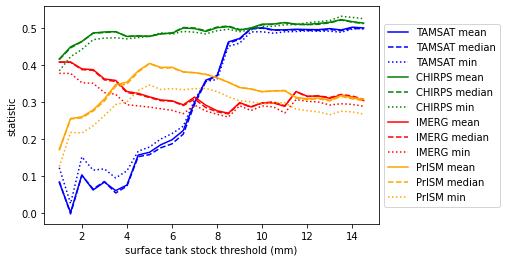

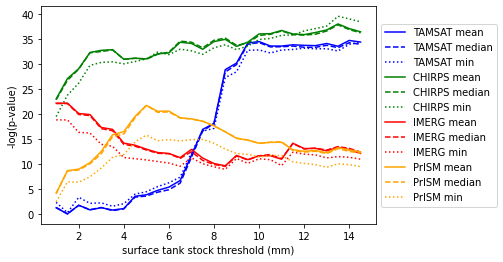

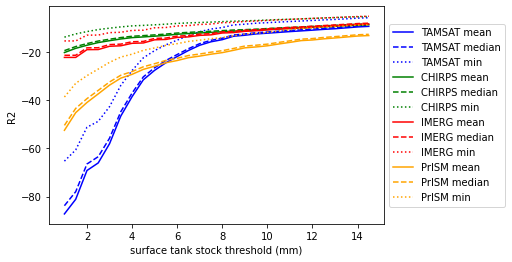

In [36]:
result_df["-log(p-value)"] = -np.log10(result_df["pvalue"])

cases = {"sowing_date_julian_mean":"-",
            "sowing_date_julian_median":"--",
            "sowing_date_julian_min":":"}

colors = {"TAMSAT":"blue",
            "CHIRPS":"green",
            "IMERG":"red",
            "PrISM":"orange"}

for statistic in ["statistic", "-log(p-value)", "R2"]:
    plt.rcParams['figure.figsize'] = [6,4]
    fig, ax = plt.subplots()
    for variable_name in ["TAMSAT", "CHIRPS", "IMERG", "PrISM"]:
        for case in cases:
            ax.plot(result_df[(result_df["metric"]==case) & (result_df["rainfall_data_name"]==variable_name)]["surface_tank_stock_thres"], result_df[(result_df["metric"]==case) & (result_df["rainfall_data_name"]==variable_name)][statistic], linestyle=cases[case], color=colors[variable_name], label=variable_name+" "+case.replace("sowing_date_julian_",""))
        # ax.set_title("{} between rain_3d_ok_day\nand {} plausible sowing date per department".format(statistic, case))

    ax.set_xlabel("surface tank stock threshold (mm)")
    ax.set_ylabel(statistic)
    # display legend positioned on the right side
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    # save the four plots including the legend
    fig.savefig("./exemple_7/{}_{}_filtre_oldsoil.png".format(statistic,species), dpi=300, bbox_inches='tight')

In [37]:
result_df[result_df["statistic"]==result_df["statistic"].max()]

,rainfall_data_name,surface_tank_stock_thres,metric,statistic,pvalue,R2,-log(p-value)
161,CHIRPS,13.5,sowing_date_julian_min,0.532495,2.304530e-40,-5.353003,39.637418


In [38]:
result_df[result_df["-log(p-value)"]==result_df["-log(p-value)"].max()]

,rainfall_data_name,surface_tank_stock_thres,metric,statistic,pvalue,R2,-log(p-value)
161,CHIRPS,13.5,sowing_date_julian_min,0.532495,2.304530e-40,-5.353003,39.637418
